In [ ]:
!pip install tensorboard
!pip install tensorboard-data-server
!pip install google-cloud-storage
!pip install tbparse matplotlib seaborn pandas numpy


In [ ]:
# ============================================================================
# GOOGLE CLOUD STORAGE (GCS) SETUP
# ============================================================================

# This sets up gcsfuse to mount a Google Cloud Storage bucket for model storage.
# ============================================================================

from google.colab import auth
auth.authenticate_user()

# Install gcsfuse
!echo "deb http://packages.cloud.google.com/apt gcsfuse-bionic main" > /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | apt-key add -
!apt -qq update
!apt -qq install gcsfuse


In [ ]:
#Create local directory and mount from GCS bucket
!mkdir pegasus_large_50k
!gcsfuse --implicit-dirs pegasus_large_50k_3rd pegasus_large_50k


In [ ]:
!mkdir pegasus_large_10k
!gcsfuse --implicit-dirs pegasus_large_10k_2nd pegasus_large_10k

In [ ]:
!mkdir pegasus_large_2k
!gcsfuse --implicit-dirs pegasus_2k_model pegasus_large_2k

In [ ]:
!mkdir pegasus_cnn_daily_mail_2k
!gcsfuse --implicit-dirs pegasus_cnn_daily_mail_2k pegasus_cnn_daily_mail_2k

In [ ]:
!mkdir pegasus_cnn_daily_mail_10k
!gcsfuse --implicit-dirs pegasus_cnn_daily_mail_10k pegasus_cnn_daily_mail_10k

In [ ]:
!mkdir pegasus_cnn_daily_mail_50k
!gcsfuse --implicit-dirs pegasus_cnn_daily_mail_50k_3rd_run pegasus_cnn_daily_mail_50k

In [ ]:
!mkdir t5_base_2k
!gcsfuse --implicit-dirs t5_base_2k_final t5_base_2k

In [ ]:
!mkdir t5_base_10k
!gcsfuse --implicit-dirs t5_large_10_run t5_base_10k

In [ ]:
!mkdir t5_base_50k
!gcsfuse --implicit-dirs t5_base_50k_final t5_base_50k

In [ ]:
!mkdir t5_large_2k
!gcsfuse --implicit-dirs models_regularized_run t5_large_2k

In [ ]:
!mkdir t5_large_10k
!gcsfuse --implicit-dirs t5_large_10_run t5_large_10k

In [ ]:
!mkdir t5_large_50k
!gcsfuse --implicit-dirs t5_large_10_run t5_large_50k

In [16]:

RUNS = {
    "pegasus_large_2k": '/content/pegasus_large_2k/models/results_pegasus-large/logs',
    "pegasus_large_10k": '/content/pegasus_large_10k/logs',
    "pegasus_large_50k": '/content/pegasus_large_50k/logs',

    'pegasus_cnn_daily_mail_2k':'/content/pegasus_cnn_daily_mail_2k/2k_samples/logs',
    'pegasus_cnn_daily_mail_10k':'/content/pegasus_cnn_daily_mail_10k/logs',
    'pegasus_cnn_daily_mail_50k':'/content/pegasus_cnn_daily_mail_50k/logs',

    't5_base_2k':'/content/t5_base_2k/2k_samples',
    "t5_base_10k": "/content/t5_base_10k/10k_samples_fixed",
    't5_base_50k':'/content/t5_base_50k/50k_samples',

    't5_large_2k':'/content/t5_large_2k/models/results_t5_large/2k_samples',
    't5_large_10k':'/content/t5_large_10k/10k_samples_fixed',
    't5_large_50k':'/content/t5_large_50k/50k_samples_fixed',

RUN_SIZES = {
    "t5_base_2k": "t5_base_2k",
    "t5_base_10k": "t5_base_10k",
    "t5_base_50k": "t5_base_50k",

    "t5_large_2k":"t5_large_2k",
    "t5_large_10k":"t5_large_10k",
    "t5_large_50k":"t5_large_50k",

    "pegasus_large_2k":"pegasus_large_2k",
    "pegasus_large_10k": "pegasus_large_10k",
    "pegasus_large_50k": "pegasus_large_50k",

    "pegasus_cnn_daily_mail_2k":"pegasus_cnn_daily_mail_2k",
    "pegasus_cnn_daily_mail_10k":"pegasus_cnn_daily_mail_10k",
    "pegasus_cnn_daily_mail_50k":"pegasus_cnn_daily_mail_50k",
}

In [17]:
import pandas as pd
from tbparse import SummaryReader
import os

def load_run(run_path):
    reader = SummaryReader(run_path, pivot=False)
    df = reader.scalars  # TensorBoard scalars
    return df


In [ ]:
from tbparse import SummaryReader

files = [f for f in os.listdir('/content/pegasus_cnn_daily_mail_50k/logs') if "events.out" in f]

for f in files:
    fp = os.path.join('/content/pegasus_cnn_daily_mail_50k/logs', f)
    print(f"\nTrying to load: {fp}")

    try:
        reader = SummaryReader(fp, pivot=False)
        df = reader.scalars
        print("Loaded scalars:", len(df))
        print(df.head())
    except Exception as e:
        print("❌ FAILED to load:", e)


In [19]:
def extract_metrics(run_name, run_path):
    import os
    import pandas as pd
    from tbparse import SummaryReader

    # Read event logs (auto-detect format: long or wide)
    reader = SummaryReader(run_path)
    df = reader.scalars

    # Detect long vs wide format
    is_long_format = "tag" in df.columns

    # Helper to extract values for a given tag in both formats
    def get_values(tag):
        if is_long_format:
            sub = df[df["tag"] == tag]
            return sub[["step", "value"]] if not sub.empty else None
        else:
            if tag in df.columns:
                # wide format: 'step' + tag column
                sub = df[["step", tag]].dropna()
                sub = sub.rename(columns={tag: "value"})
                return sub if not sub.empty else None
            else:
                return None

    # --- 1. TRAIN LOSS ---
    train_loss_raw = get_values("train/loss")
    if train_loss_raw is not None:
        train_loss = pd.DataFrame({
            "step": train_loss_raw["step"].values,
            "loss": train_loss_raw["value"].values
        })
    else:
        train_loss = None

    # --- 2. VALIDATION LOSS ---
    val_loss_raw = get_values("eval/loss")
    if val_loss_raw is not None:
        val_loss = pd.DataFrame({
            "step": val_loss_raw["step"].values,
            "loss": val_loss_raw["value"].values
        })
    else:
        val_loss = None

    # --- 3. ROUGE METRICS ---
    def get_last_metric(tag):
        m = get_values(tag)
        return m["value"].iloc[-1] if m is not None and not m.empty else None

    rouge1 = get_last_metric("eval/rouge1")
    rouge2 = get_last_metric("eval/rouge2")
    rougeL = get_last_metric("eval/rougeL")

    # --- 4. GPU USAGE ---
    gpu_raw = get_values("gpu_memory_gb")
    gpu_avg = gpu_raw["value"].mean() if gpu_raw is not None else None

    # --- 5. TRAINING TIME ---
    tt_raw = get_values("total_training_time_seconds")
    train_time = tt_raw["value"].iloc[0] if tt_raw is not None else None


    # --- FINAL OUTPUT ---
    return {
        "run": run_name,
        "train_loss": train_loss,
        "val_loss": val_loss,
        "rouge1": rouge1,
        "rouge2": rouge2,
        "rougeL": rougeL,
        "gpu_avg": gpu_avg,
        "train_time_sec": train_time,
    }


In [20]:
all_metrics = []

for run_name, run_path in RUNS.items():
    metrics = extract_metrics(run_name, run_path)
    all_metrics.append(metrics)

summary_df = pd.DataFrame([{
    "run": m["run"],
    "rouge1": m["rouge1"],
    "rouge2": m["rouge2"],
    "rougeL": m["rougeL"],
    "gpu_avg": m["gpu_avg"],
    "train_time_min": m["train_time_sec"] / 60 if m["train_time_sec"] else None,
} for m in all_metrics])

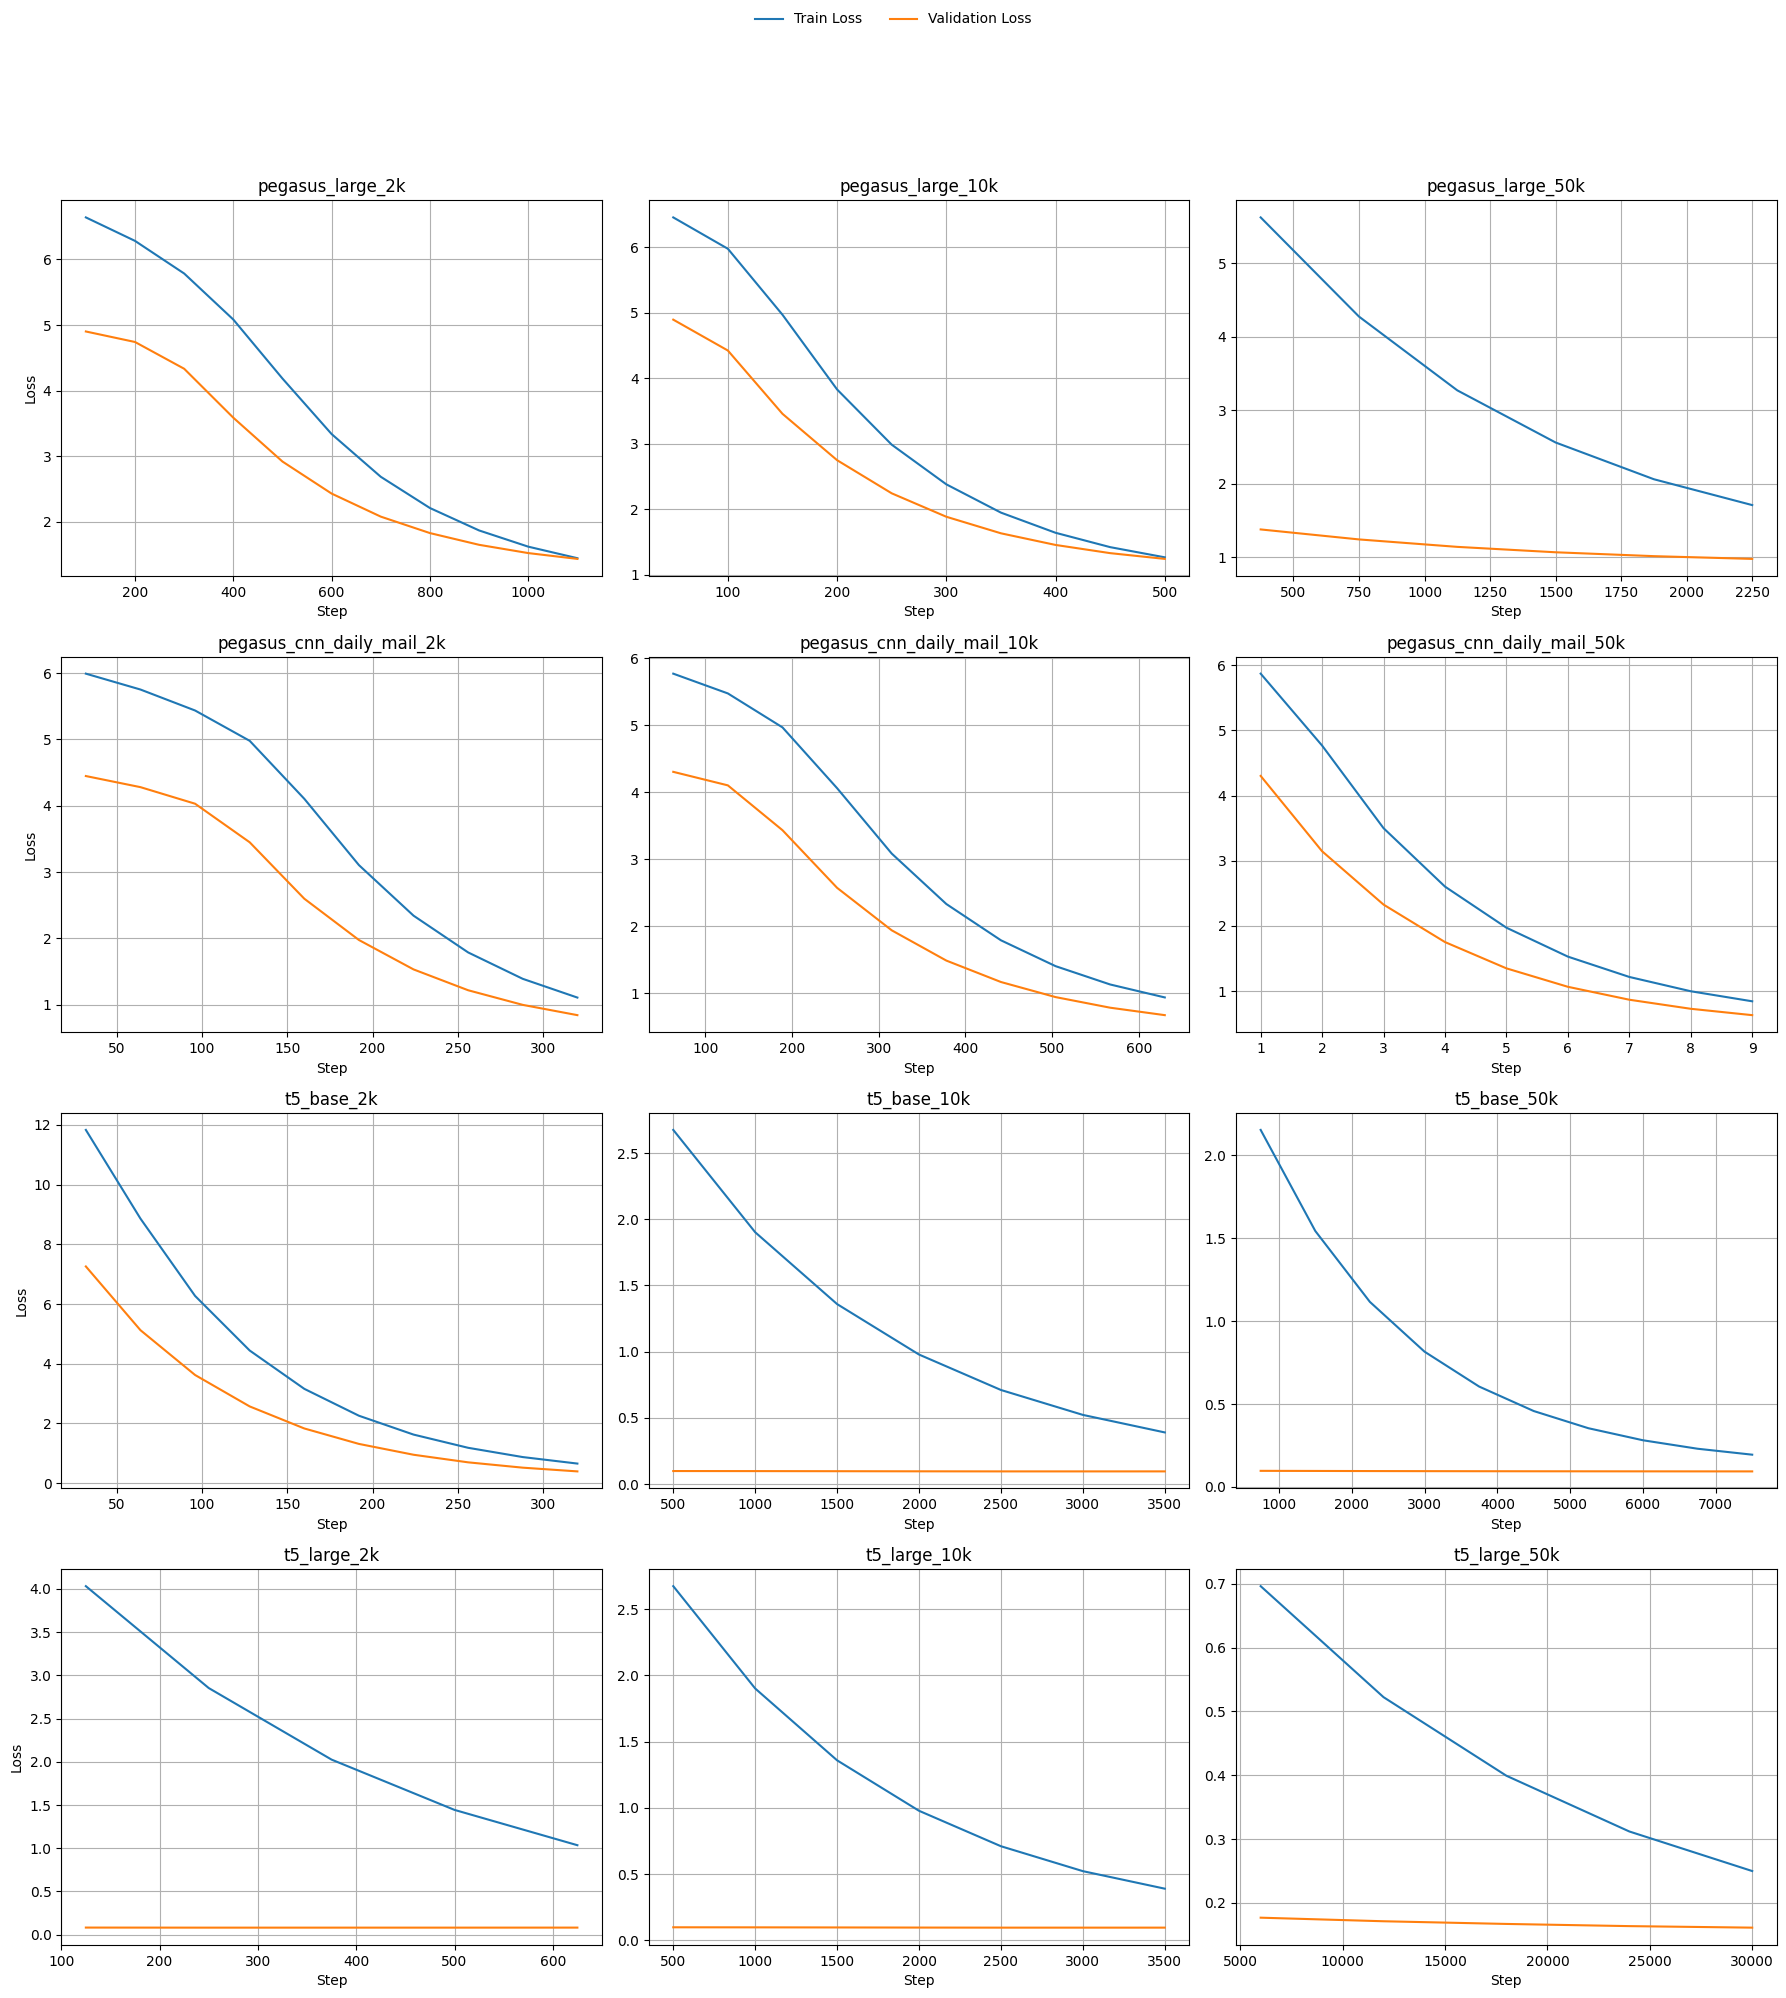

In [27]:
import math
import matplotlib.pyplot as plt

# --- EMA smoothing ---
def ema(values, alpha=0.3):
    values = list(values)
    if not values:
        return values
    smoothed = [values[0]]
    for v in values[1:]:
        smoothed.append(alpha * v + (1 - alpha) * smoothed[-1])
    return smoothed


# --- Filter valid runs safely ---
valid_runs = [
    m for m in all_metrics
    if m.get("train_loss") is not None
    and m.get("val_loss") is not None
    and not m["train_loss"].empty
    and not m["val_loss"].empty
]

if not valid_runs:
    raise ValueError("No valid runs found to plot.")

# --- Layout config ---
plots_per_row = 3
n = len(valid_runs)
rows = math.ceil(n / plots_per_row)

fig, axes = plt.subplots(
    rows,
    plots_per_row,
    figsize=(6 * plots_per_row, 5 * rows), # qetu nese don me e rrit/zvoglu figuren
    sharey=False #nese don me pas scale t njejt n krejt figurat
)

# Flatten axes for easy indexing
axes = axes.flatten()

# --- Plot each run ---
for i, m in enumerate(valid_runs):
    ax = axes[i]


    train_steps = m["train_loss"]["step"]
    train_loss = m["train_loss"]["loss"]

    val_steps = m["val_loss"]["step"]
    val_loss = m["val_loss"]["loss"]

    ax.plot(train_steps, train_loss, label="Train Loss")
    ax.plot(val_steps, val_loss, label="Validation Loss")

    ax.set_title(m["run"])
    ax.set_xlabel("Step")
    ax.grid(True)

# --- Remove unused axes (if any) ---
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# --- Shared Y label ---
for ax in axes[::plots_per_row]:
    ax.set_ylabel("Loss")

# --- Single legend for all plots ---
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc="upper center",
    ncol=2,
    frameon=False
)

plt.tight_layout(rect=[0, 0, 1, 0.92])
plt.show()


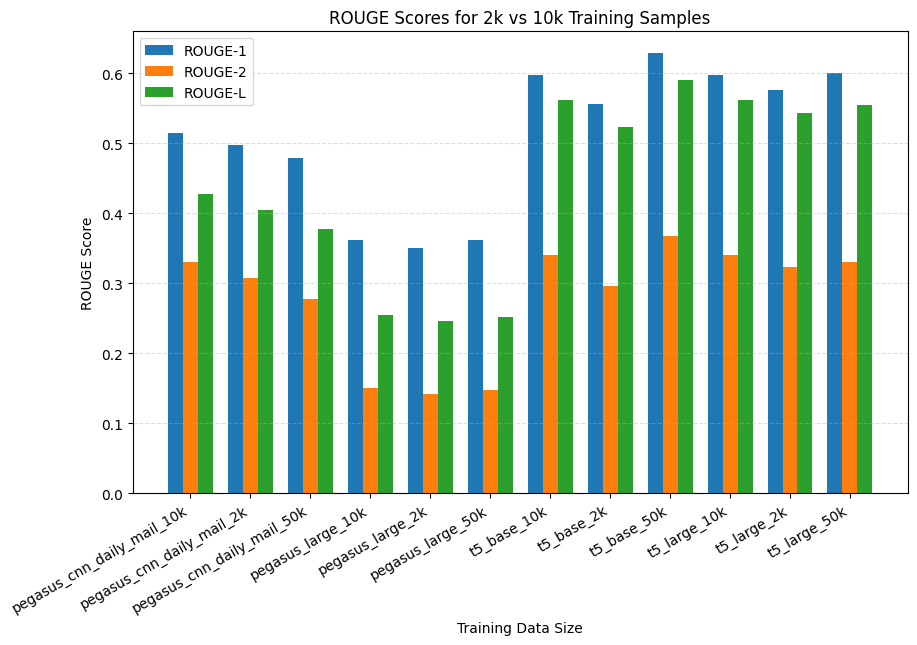

In [28]:
import matplotlib.pyplot as plt
import numpy as np

summary_df["data_size"] = summary_df["run"].map(RUN_SIZES)
df_sorted = summary_df.sort_values("data_size")

sizes = df_sorted["data_size"].tolist()
rouge1 = df_sorted["rouge1"].tolist()
rouge2 = df_sorted["rouge2"].tolist()
rougeL = df_sorted["rougeL"].tolist()

x = np.arange(len(sizes))  # number of groups
width = 0.25               # width of each bar

plt.figure(figsize=(10,6))

plt.bar(x - width, rouge1, width, label='ROUGE-1')
plt.bar(x,         rouge2, width, label='ROUGE-2')
plt.bar(x + width, rougeL, width, label='ROUGE-L')

plt.xticks(x, sizes, rotation=30, ha="right")
plt.xlabel("Training Data Size")
plt.ylabel("ROUGE Score")
plt.title("ROUGE Scores for 2k vs 10k Training Samples")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

plt.show()
